In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

import warnings
warnings.simplefilter("ignore")

plt.style.use('ggplot')

Using TensorFlow backend.


In [ ]:
data_file = 'E:/DigitalMarketing/AssigmnetPart2/criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')
df0.head()

In [3]:
df_ext = df0.copy()
df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
min_max_scaler = MinMaxScaler()
for cname in ('timestamp', 'time_since_last_click'):
    x = df_ext[cname].values.reshape(-1, 1) 
    df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)

In [4]:
# random sampling 400 campaigns
n_campaigns = 10
campaigns = np.random.choice( df_ext['campaign'].unique(), n_campaigns, replace = False )
df_1 = df_ext[ df_ext['campaign'].isin(campaigns) ]

In [5]:
# campaings with minimun touchpoints 2

min_touchpoints = 2
grouped = df_1.groupby(['jid'])['uid'].count().reset_index(name="count")
df_2 =  df_1[df_1['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

In [6]:
# campaign with minimum touchpoints 2 used in our code

min_touchpoints = 2
df_converted = df_ext[df_ext['conversion'] == 1]
conv_group = df_converted.groupby(['uid', 'campaign']).count().reset_index()
multi_camps = conv_group.groupby(['uid'])['campaign'].count().reset_index()

In [7]:
conv_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336748 entries, 0 to 336747
Data columns (total 25 columns):
uid                           336748 non-null int64
campaign                      336748 non-null int64
timestamp                     336748 non-null int64
conversion                    336748 non-null int64
conversion_timestamp          336748 non-null int64
conversion_id                 336748 non-null int64
attribution                   336748 non-null int64
click                         336748 non-null int64
click_pos                     336748 non-null int64
click_nb                      336748 non-null int64
cost                          336748 non-null int64
cpo                           336748 non-null int64
time_since_last_click         336748 non-null int64
cat1                          336748 non-null int64
cat2                          336748 non-null int64
cat3                          336748 non-null int64
cat4                          336748 non-null int64
cat5 

In [1]:
# user ID where they have been converted for more than 2 campaigns
uid_values = multi_camps[multi_camps['campaign'] > min_touchpoints]['uid'].values
campaign_values = multi_camps[multi_camps['campaign'] > min_touchpoints]['campaign'].values

NameError: name 'multi_camps' is not defined

In [9]:
# unique user ID and campaign ID
uid_unique, uid_indices = np.unique(uid_values, return_inverse=True)
campaign_unique, campaign_indices = np.unique(uid_values, return_inverse=True)

In [10]:
# sampling data based on UID or Campaign 
df_attribution_data =  df_ext[(df_ext['uid'].isin( uid_values)) | (df_ext['campaign'].isin(campaign_values))]
df_attribution_data = df_attribution_data.reset_index(drop = 1)

In [11]:
df_minority = df_attribution_data[df_attribution_data.conversion == 1]
df_majority = df_attribution_data[df_attribution_data.conversion == 0]
df_minority = df_minority.loc[df_minority.groupby(['uid', 'campaign'])['timestamp'].idxmax()]
df_majority = df_majority.loc[df_majority.groupby(['uid', 'campaign'])['timestamp'].idxmax()]

In [12]:
print('converted count:',df_minority.shape[0],'\not converted count:',df_majority.shape[0])

converted count: 1386 
ot converted count: 1743


In [13]:
df_2 = pd.concat([df_minority, df_majority])

In [14]:
print(df_2.shape[0])
print([df_2[df_2.conversion == 0].shape[0], df_2[df_2.conversion == 1].shape[0]])

3129
[1743, 1386]


In [15]:
df_2[df_2['conversion'] == 1]['uid'].value_counts()

10386355    7
5453639     6
11852675    5
5381156     5
23581753    5
           ..
994542      3
5592306     3
18253044    3
10206461    3
7723008     3
Name: uid, Length: 442, dtype: int64

In [16]:
column_names = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8']

mapper = {} 
for i, col_name in enumerate(column_names):
    for val in df_ext[col_name].unique():
        mapper[str(val) + str(i)] = len(mapper)
         
df_3 = df_2.copy()
    
def one_hot(values):
    v = np.zeros( len(mapper) )
    for i, val in enumerate(values): 
        v[ mapper[str(val) + str(i)] ] = 1
    return v    
    
df_3['cats'] = df_3[column_names].values.tolist()
df_3['cats'] = df_3['cats'].map(one_hot)

In [17]:
column_names = ['campaign']

mapper = {} 
for i, col_name in enumerate(column_names):
    for val in df_2[col_name].unique():
        mapper[str(val) + str(i)] = len(mapper)
         
df_4 = df_3.copy()
    
def one_hot(values):
    v = np.zeros( len(mapper) )
    for i, val in enumerate(values): 
        v[ mapper[str(val) + str(i)] ] = 1
    return v    
    
df_4['campaigns'] = df_4[column_names].values.tolist()
df_4['campaigns'] = df_4['campaigns'].map(one_hot)

In [18]:
print(df_4.shape[0])
print([df_4[df_4.conversion == 0].shape[0], df_4[df_4.conversion == 1].shape[0]])

3129
[1743, 1386]


In [19]:
len(df_4['campaign'].unique())

379

### Last Touch Attribution

In [20]:
def last_touch_attribution(df):
    #count campaign unique in DF 
    campaign_count = len(df['campaign'].unique())
    
    def count_by_campaign(df):
        counters = np.zeros(campaign_count)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['uid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df_4)

In [42]:
# lta

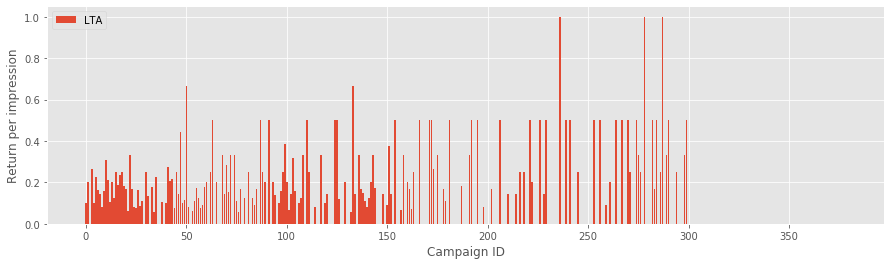

In [22]:
# Visualization of the attribution scores

campaign_idx = range(0, len(df_4['campaign'].unique()))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [192]:
fig = plt.figure()
x1 = np.linspace(0.0, 379.0, len(plot["campaign"]))
y = plot["lta"].cumsum()
l2 = plt.plot(x1, y, colors=['hotpink'],labels=['LTA'],display_legend=True)
# plt.legend_location['top-right’]
plt.show()

### First Touch Attribution

In [23]:
def first_touch_attribution(df):
    campaign_count = len(df['campaign'].unique())
    
    def count_by_campaign(df):
        counters = np.zeros(campaign_count)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['uid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df_4)

In [24]:
np.argmax(lta)

236

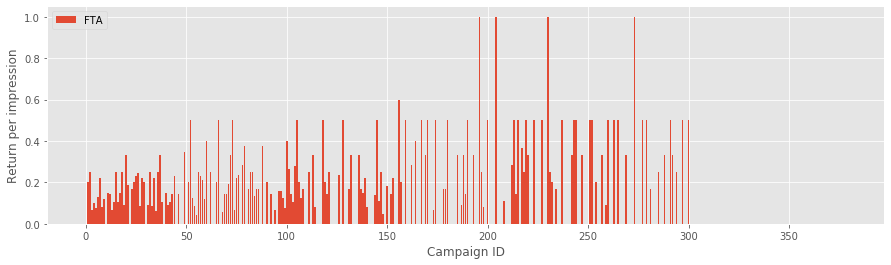

In [25]:
# Visualization of the attribution scores

campaign_idx = range(0, len(df_4['campaign'].unique()))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [195]:
fig = plt.figure()
x1 = np.linspace(0.0, 379.0, len(plot["campaign"]))
y = plot["fta"].cumsum()
l2 = plt.plot(x1, y, colors=['red'],labels=['FTA'],display_legend=True)
# plt.legend_location['top-right’]
plt.show()

### Linear Attribution

In [26]:
def linear_attribution(df):
    campaign_count = len(df['campaign'].unique())
    
    def count_by_campaign(df):
        counters = np.zeros(campaign_count)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id]  = counters[campaign_id] + campaign_one_hot[campaign_id]
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    df_converted['count'] = df_converted.groupby(['uid']).transform('count')['timestamp']
    df_converted['U_attribution'] = df_converted['count'].transform(lambda x: 1/x)
    df_converted['campaigns'] = df_converted['campaigns'] * df_converted['U_attribution']
    campaign_conversions = count_by_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
la = linear_attribution(df_4)

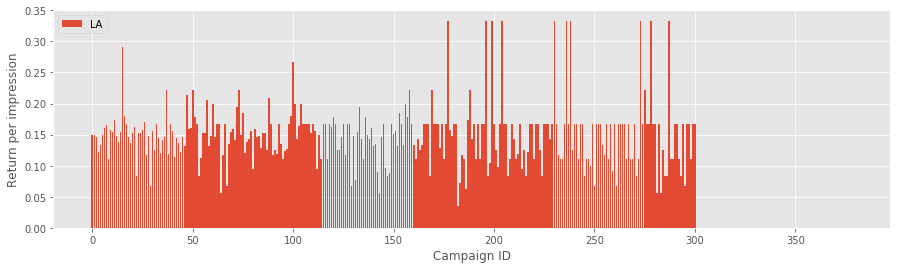

In [27]:
# Visualization of the attribution scores

campaign_idx = range(0, len(df_4['campaign'].unique()))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(la[campaign_idx])), la[campaign_idx], label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [196]:
fig = plt.figure()
x1 = np.linspace(0.0, 379.0, len(plot["campaign"]))
y = plot["la"].cumsum()
l2 = plt.plot(x1, y, colors=['green'],labels=['LA'],display_legend=True)
# plt.legend_location['top-right’]
plt.show()

### U Touch Attribution

In [28]:
def U_touch_attribution(df):
    campaign_count = len(df['campaign'].unique())
    
    def count_by_campaign(df):
        counters = np.zeros(campaign_count)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id]  = counters[campaign_id] + campaign_one_hot[campaign_id]
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    df_converted['count'] = df_converted.groupby(['uid']).transform('count')['timestamp']
    df_converted['U_attribution'] = df_converted['count'].transform(lambda x: .2/(x-2))
    idx_min = df_converted.groupby(['uid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    idx_max = df_converted.groupby(['uid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    idx_min = idx_min.reset_index()
    idx_max = idx_max.reset_index()
    df_converted.loc[idx_min[idx_min['timestamp_norm'] == True]['index'].values,'U_attribution'] = 0.4
    df_converted.loc[idx_max[idx_max['timestamp_norm'] == True]['index'].values,'U_attribution'] = 0.4
    df_converted['campaigns'] = df_converted['campaigns'] * df_converted['U_attribution']

    campaign_conversions = count_by_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
uta = U_touch_attribution(df_4)

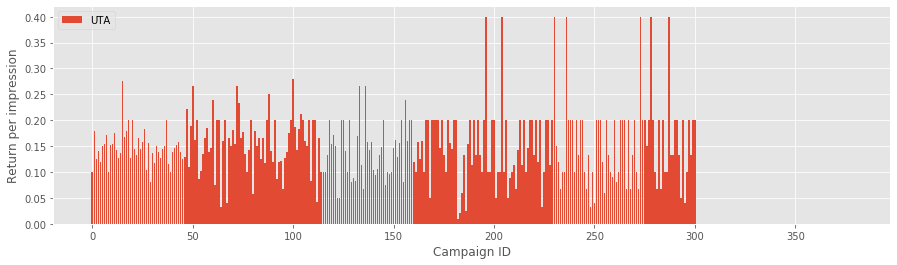

In [29]:
# Visualization of the attribution scores

campaign_idx = range(0, len(df_4['campaign'].unique()))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(uta[campaign_idx])), uta[campaign_idx], label='UTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [199]:
fig = plt.figure()
x1 = np.linspace(0.0, 379.0, len(plot["campaign"]))
y = plot["uta"].cumsum()
l2 = plt.plot(x1, y, colors=['blue'],labels=['UTA'],display_legend=True)
# plt.legend_location['top-right’]
plt.show()

### Time Decay Attribution

In [30]:
'''import datetime

df_minority['transactionTime'] = pd.to_datetime(df_minority['transactionTime'], unit='s')
df_minority['transactionTime'] = pd.to_datetime(df['transactionTime'], format = '%m/%d/%Y')'''

"import datetime\n\ndf_minority['transactionTime'] = pd.to_datetime(df_minority['transactionTime'], unit='s')\ndf_minority['transactionTime'] = pd.to_datetime(df['transactionTime'], format = '%m/%d/%Y')"

In [31]:
#Ushaped testing

df_minority = df_4[df_4['conversion'] == 1]
df_minority['count'] = df_minority.groupby(['uid']).transform('count')['timestamp']
df_minority['U_attribution'] = df_minority['count'].transform(lambda x: .2/(x-2))
idx_min = df_minority.groupby(['uid'])['timestamp_norm'].transform(min) == df_minority['timestamp_norm']
idx_max = df_minority.groupby(['uid'])['timestamp_norm'].transform(max) == df_minority['timestamp_norm']
idx_min = idx_min.reset_index()
idx_max = idx_max.reset_index()
df_minority.loc[idx_min[idx_min['timestamp_norm'] == True]['index'].values,'U_attribution'] = 0.4
df_minority.loc[idx_max[idx_max['timestamp_norm'] == True]['index'].values,'U_attribution'] = 0.4
df_minority['campaigns'] = df_minority['campaigns'] * df_minority['U_attribution']

In [32]:
# Linear testing
df_minority = df_4[df_4['conversion'] == 1]
df_minority['count'] = df_minority.groupby(['uid']).transform('count')['timestamp']
df_minority['U_attribution'] = df_minority['count'].transform(lambda x: 1/x)
# idx_min = df_minority.groupby(['uid'])['timestamp_norm'].transform(min) == df_minority['timestamp_norm']
# idx_max = df_minority.groupby(['uid'])['timestamp_norm'].transform(max) == df_minority['timestamp_norm']
# idx_min = idx_min.reset_index()
# idx_max = idx_max.reset_index()
# df_minority.loc[idx_min[idx_min['timestamp_norm'] == True]['index'].values,'U_attribution'] = 0.4
# df_minority.loc[idx_max[idx_max['timestamp_norm'] == True]['index'].values,'U_attribution'] = 0.4
df_minority['campaigns'] = df_minority['campaigns'] * df_minority['U_attribution']

In [33]:
df_minority[df_minority['uid'] == 273804]

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,count,U_attribution
12466,2304824,273804,29389116,1,2344041,18367791,1,1,2,3,...,17464451,29196072,21091111,273804_18367791,0.862842,0.115959,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
12621,2345072,273804,31129938,1,2869520,25187625,1,1,4,7,...,15169534,29196072,8661623,273804_25187625,0.877910,0.205569,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
8174,1534653,273804,31129939,1,1812398,7534060,0,1,2,3,...,18788452,29196072,21091111,273804_7534060,0.574518,0.147162,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, ...",3,0.333333


In [34]:
# Time Decay

In [35]:
df_minority['timestamp_max'] = df_minority.groupby(['uid'])['timestamp'].transform(max)
df_minority['days'] = df_minority['timestamp_max'] - df_minority['timestamp']

In [36]:
df_minority.astype({'days': 'float64'}).dtypes
df_minority['day'] = np.floor(df_minority.days / 86400.).astype(float)

In [37]:
df_minority['time_decay_attribution'] =df_minority['days'].transform(lambda x:  2**(-x/7))

In [38]:
df_minority.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,timestamp_norm,time_since_last_click_norm,cats,campaigns,count,U_attribution,timestamp_max,days,day,time_decay_attribution
12466,2304824,273804,29389116,1,2344041,18367791,1,1,2,3,...,0.862842,0.115959,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,2345072,40248,0.0,0.0
12621,2345072,273804,31129938,1,2869520,25187625,1,1,4,7,...,0.877910,0.205569,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,2345072,0,0.0,1.0
8174,1534653,273804,31129939,1,1812398,7534060,0,1,2,3,...,0.574518,0.147162,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, ...",3,0.333333,2345072,810419,9.0,0.0
5524,1056761,292728,11321105,1,1923141,9243110,0,1,0,1,...,0.395613,0.000000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, ...",3,0.333333,1056761,0,0.0,1.0
2723,546502,292728,15321102,1,722273,28691136,0,1,0,1,...,0.204591,0.000000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, ...",3,0.333333,1056761,510259,5.0,0.0


In [39]:
# Visualization

In [59]:
import ipywidgets as widgets
import numpy as np
from bqplot import pyplot as plt
import bqplot
import ipyvuetify as v

In [114]:
y = lta
x = np.linspace(0, 500, len(df_4['campaign'].unique()))
plt.ylim(0.0, 1.0)
hist = plt.plot(x, y)
# hist.scales['sample'].min = float(y.min())
# hist.scales['sample'].max = float(y.max())
# fig.layout.width = 'auto'
# fig.layout.height = 'auto'
# fig.layout.min_height = '300px' # so it shows nicely in the notebook
fig

Figure(axes=[Axis(scale=LinearScale(), side='bottom'), Axis(orientation='vertical', scale=LinearScale(max=1.0,…

In [70]:
slider = v.Slider(thumb_label='always', class_="px-4", v_model=30)
widgets.link((slider, 'v_model'), (hist, 'bins'))
slider

Slider(class_='px-4', thumb_label='always', v_model=30)

In [154]:
plot = pd.DataFrame(list(zip(df_4['campaign'].unique(), lta, uta, fta, la)), columns = ['campaign','lta', 'uta', 'fta', 'la'])

In [155]:
plot.head()
#srs1["lta"]
# srs1["campaign"]

,campaign,lta,uta,fta,la
0,29389116,0.100000,0.100,0.000000,0.150000
1,31129938,0.200000,0.180,0.200000,0.150000
2,31129939,0.000000,0.125,0.250000,0.145833
3,11321105,0.266667,0.140,0.066667,0.122222
4,15321102,0.100000,0.120,0.100000,0.133333


In [197]:
from bqplot import pyplot as plt
%matplotlib inline
plt.figure(title='Atrribution Comparision')
x = np.linspace(0.0, 379.0, len(plot["campaign"]))
y1 = plot["lta"].cumsum()
y2 = plot["uta"].cumsum()
y3 = plot["fta"].cumsum()
y4 = plot["la"].cumsum()
l1 = plt.plot(x, y1, colors=['hotpink'],labels=['LTA'],display_legend=True)
l2 = plt.plot(x, y2, colors=['red'],labels=['UTA'],display_legend=True)
l3 = plt.plot(x, y3, colors=['green'],labels=['FTA'],display_legend=True)
l4 = plt.plot(x, y4, colors=['blue'],labels=['LA'],display_legend=True)
# plt.legend_location['top-right’]
plt.show()

In [167]:
plot['fta'].sum()

48.219093372941884

In [ ]:
campaign_idx = range(0, len(df_4['campaign'].unique()))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(uta[campaign_idx])), uta[campaign_idx], label='UTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()